# Project Overview
The goal of this project is to demonstrate Uncertainty in Deep learning.  I learned about this topic from https://www.osti.gov/servlets/purl/1733262

# Uncertainty Overview
Uncertainty is a method of showing how confident a ML algorithm is in it's predictions.  For instance, in a multiclass model, the model may have .6 for one value, .55 for a second, and .54 for the third.  This could indicate that your model is uncertain but it will always pick the top option.

Uncertainty is different from probability as uncertainty can show that the available information is not sufficient to make a competent selection.

You can use uncertainty to quantify error margins in prediction algorithms as well.  For instance, knowing uncertainty can indicate if your error margin is 1%, 10%, or 50%.  It can also let you attempt to correct for your error margin.

# Project Plan
I plan to use the dataset of fruit spoilage.  I will create very basic CNN to predict the results, and then quantify and demonstrate uncertainty.  After that, I will attempt to correct to minimize uncertainty, and show how uncertainty can be used to quantify error.

## ChatGPT/GEMINI Use
I will be using ChatGPT in this project to generate code for non-ai model purposes such as data ingest and visualization.

## This project was developed and run on Google Colab



In [1]:
from google.colab import drive
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import zipfile
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import tarfile
import os
import h5py
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import math
print("TensorFlow version:", tf.__version__)
imagesize = 100
unified_results = {}
batch_size = 32

TensorFlow version: 2.15.0


In [2]:
if os.path.exists('drive/MyDrive/Uncertanty/image_data.h5'):
  shutil.copy('drive/MyDrive/Uncertanty/image_data.h5', '.')

if not os.path.exists('Fruit And Vegetable Diseases Dataset'):
  drive.mount('/content/drive')
  # Create the .kaggle directory if it doesn't exist
  !mkdir -p /root/.kaggle

  # Copy the kaggle.json file from Google Drive to the .kaggle directory
  !cp /content/drive/My\ Drive/kaggle.json /root/.kaggle/

  # Change the permissions of the kaggle.json file to 600
  !chmod 600 /root/.kaggle/kaggle.json
  import kaggle
  # Download the dataset
  !kaggle datasets download muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten

  #Unzip the dataset
  #shutil.copy('drive/MyDrive/Uncertanty/muffin-vs-chihuahua-image-classification', '.')
  with zipfile.ZipFile('fruit-and-vegetable-disease-healthy-vs-rotten.zip', 'r') as zip_ref:
      zip_ref.extractall()


Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/muhammad0subhan/fruit-and-vegetable-disease-healthy-vs-rotten
License(s): CC0-1.0
100% 4.76G/4.77G [01:09<00:00, 99.7MB/s]
100% 4.77G/4.77G [01:09<00:00, 73.3MB/s]


In [3]:
def process_files_in_folder(folder_path):
  images = []
  labels = []
  for filename in os.listdir(folder_path):
      if filename.endswith('.jpg') or filename.endswith('.jpeg'):
        if 'Healthy' in folder_path:
          labels.append(1)
        else:
          labels.append(0)
        image = Image.open(os.path.join(folder_path, filename))
        image = image.resize((imagesize, imagesize)).convert('RGB')
        images.append(np.array(image))
  return pd.DataFrame({'image': images, 'label': labels})
if not os.path.exists('image_data.h5'):
  train = pd.DataFrame()
  train = pd.concat([train,process_files_in_folder('Fruit And Vegetable Diseases Dataset/Apple__Healthy')])
  train = pd.concat([train,process_files_in_folder('Fruit And Vegetable Diseases Dataset/Apple__Rotten')])
  #Convert To Numpy
  train_data = np.stack(train['image'].to_list(),axis = 0)
  train_targets = np.stack(train['label'].to_list(),axis = 0)
  #Save Numpy to file for faster loading later
  h5f = h5py.File('image_data.h5', 'w')
  h5f.create_dataset('train_data', data=train_data)
  h5f.create_dataset('train_targets', data=train_targets)
  h5f.close()
  del train
  #Save for faster loading later
  shutil.copy('image_data.h5', 'drive/MyDrive/Uncertanty/image_data.h5')

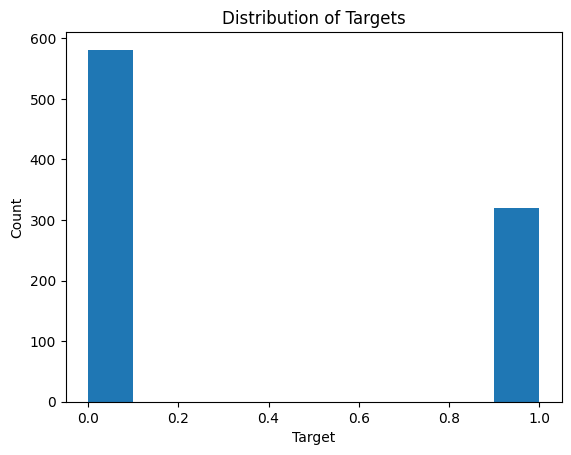

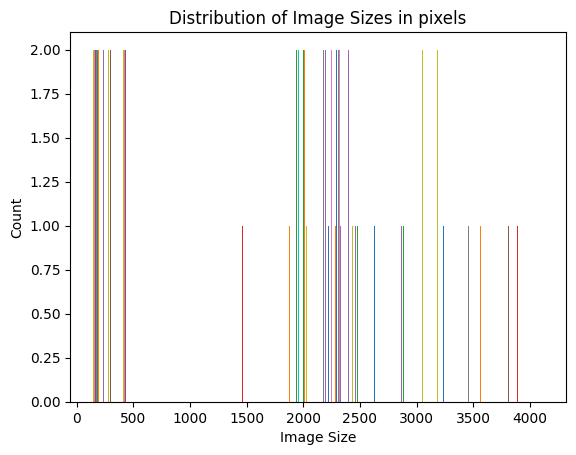

In [10]:
h5f = h5py.File('image_data.h5', 'r')
train = h5f['train_data'][:]
targets = h5f['train_targets'][:]

h5f.close()
#Split the data into training and validation sets
train_data, val_data, train_targets, val_targets = train_test_split(train, targets, test_size=0.2, random_state=42)

plt.hist(targets)
plt.title('Distribution of Targets')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()
imsizes = []
folder_path = 'Fruit And Vegetable Diseases Dataset/Apple__Healthy'
for image in os.listdir(folder_path):
  if image.endswith('.jpg') or image.endswith('.jpeg'):
    im = Image.open(os.path.join(folder_path, image))
    imsizes.append(im.size)
plt.hist(imsizes)
plt.title('Distribution of Image Sizes in pixels')
plt.xlabel('Image Size')
plt.ylabel('Count')
plt.show()

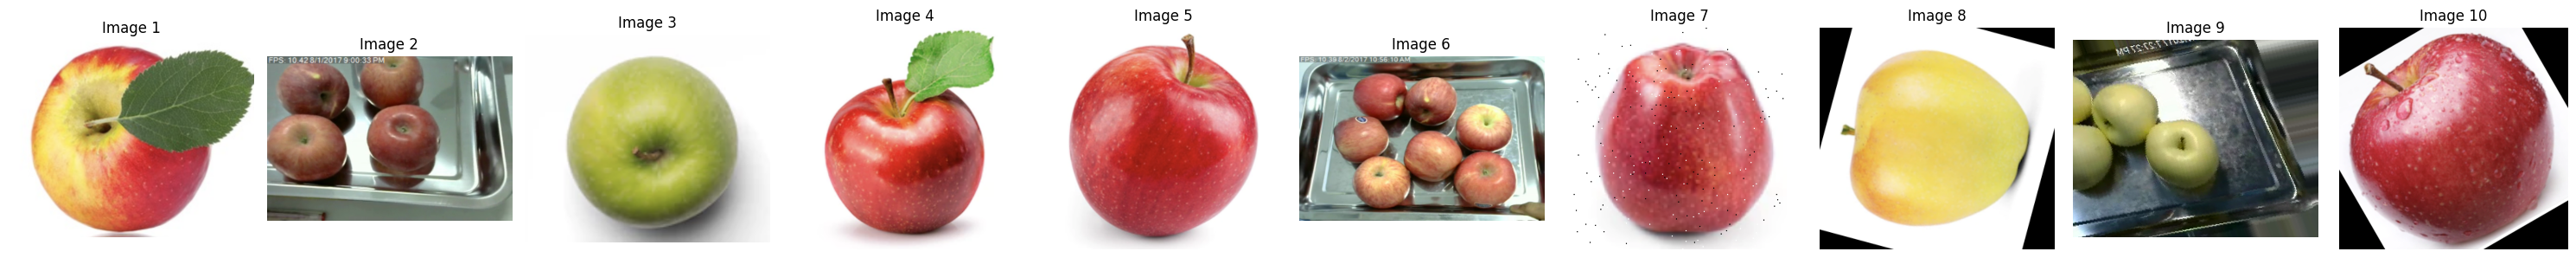

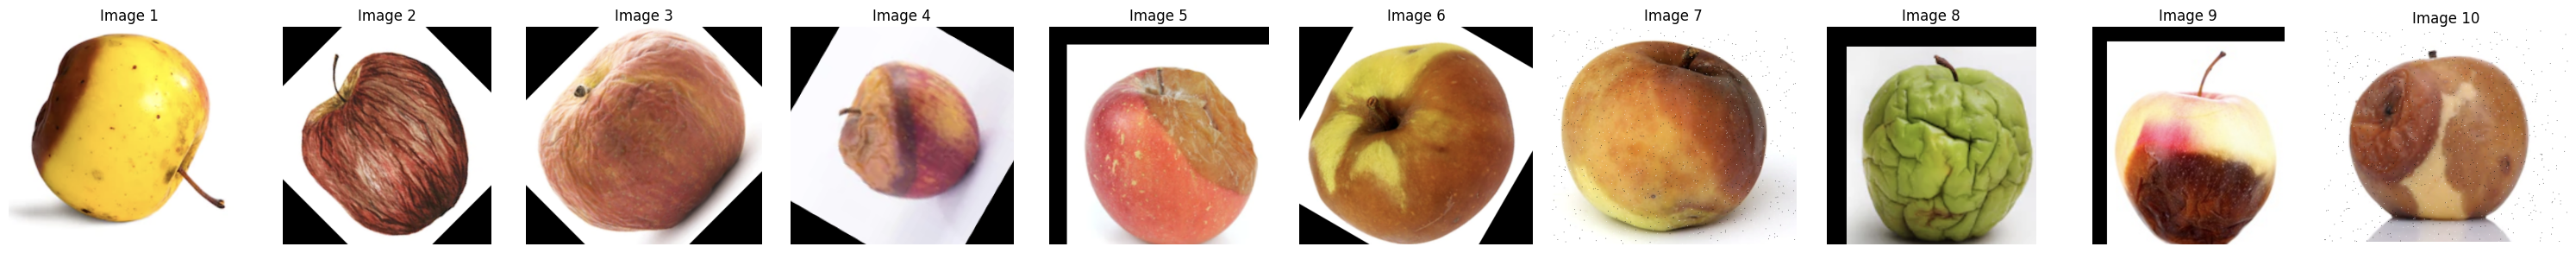

There are 2438 healthy images and 2930 rotten images


In [7]:
def load_and_display_images(folder, num_images=10):
    # Get a list of all image files in the folder
    images = [os.path.join(folder, img) for img in os.listdir(folder) if img.endswith(('jpg', 'jpeg', 'png', 'bmp'))]

    # Randomly select num_images from the folder
    selected_images = random.sample(images, num_images)

    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    # Display images from the folder
    for i, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()
load_and_display_images('Fruit And Vegetable Diseases Dataset/Apple__Healthy')
load_and_display_images('Fruit And Vegetable Diseases Dataset/Apple__Rotten')
print(f"There are {len(os.listdir('Fruit And Vegetable Diseases Dataset/Apple__Healthy'))} healthy images"
      f" and {len(os.listdir('Fruit And Vegetable Diseases Dataset/Apple__Rotten'))} rotten images")



# EDA
## Data Description
There are 2438 healthy images and 2930 rotten images.  
I chose to only use apples to keep training times low.  The images were various sizes, but I resized them all to 100x100.  This resizing will lead to an increased uncertainty, and allow for uniform processing.  
## Data Transformations
All images were resized to 100x100x3 for easier processing

## Hypothesis
I think that a simple CNN will work fairly well and will have a fairly low uncertainty.  This is caused by regular features of both the Healthy and Rotten apples.

## Outliers (Apples on Trays)
Some of the images of apples are on trays.  In several random looks, all the apples on trays are good apples.  I don't plan to clean these as I am trying to show uncertainty and this could drive uncertainty.



# Uncertainty Demonstration
To explain uncertainty, I will provide graphical demonstrations.
I will be using a binary classification model.  When the model is run 100 times there are minor variations between the runs.  Optimally you should get the model always getting the same results.  This does not often happen unless you have a very well tuned model and great data.  

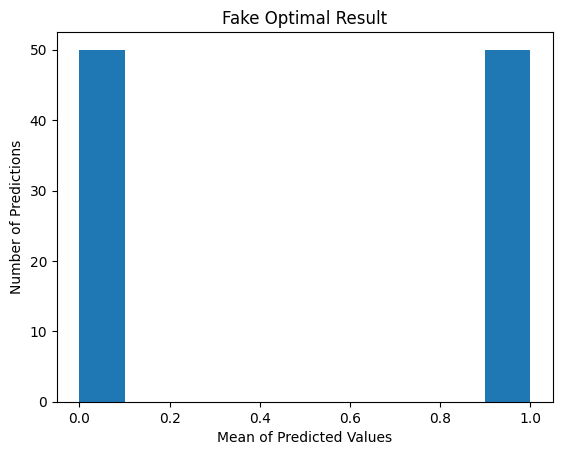

In [11]:
fake_data = []
for i in range(0,50):
  fake_data.append(0)
for i in range(0,50):
  fake_data.append(1)
plt.hist(fake_data)
plt.xlabel('Mean of Predicted Values')
plt.ylabel('Number of Predictions')
plt.title('Fake Optimal Result')

plt.show()

# Less Optimal Scenarios
In a less optimal Scenario, when you test your model with 100 runs, you will have some of the predictions of an image be different for different model runs.  This is what this may look like.

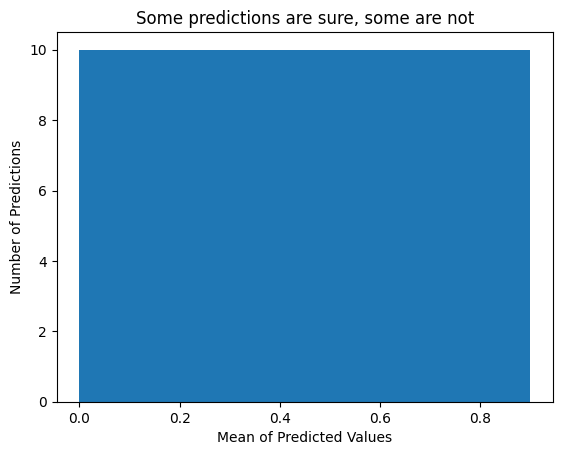

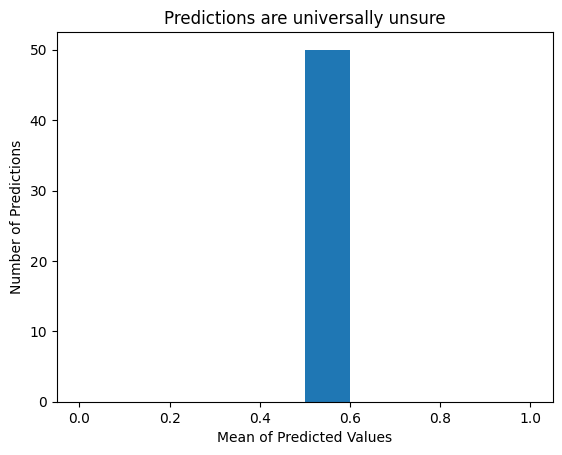

In [7]:
fake_data = []
for i in range(0,10):
  for j in range(0,10):
    fake_data.append(i/10)
plt.hist(fake_data)
plt.xlabel('Mean of Predicted Values')
plt.ylabel('Number of Predictions')
plt.title('Some predictions are sure, some are not')
plt.show()
fake_data = []
for i in range(0,50):
  fake_data.append(.5)
plt.hist(fake_data)
plt.xlabel('Mean of Predicted Values')
plt.ylabel('Number of Predictions')
plt.title('Predictions are universally unsure')
plt.show()


In [8]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
# Show 10 images in a 5x2 shape
def show_max_uncertain(mean, std, val_data):
  mean = mean[:,0]
  max_uncertain = np.argwhere((mean > 0.4) & (mean < 0.6))
  print(max_uncertain)
  rand_images = random.sample(list(max_uncertain), 10)
  numrows = 2
  fig, ax = plt.subplots(numrows, 5, figsize=(7, numrows))
  fig.suptitle('Most Uncertain Images')
  for i, image_num in enumerate(rand_images):
      ax[i // 5, i % 5].imshow(val_data[image_num])
      ax[i // 5, i % 5].axis('off')

  std1 = std[:,0]
  sorted_indices = np.argsort(std1)[::-1]

# Select the top 10 elements
  top_10_indices = sorted_indices[:10]
  fig, ax = plt.subplots(numrows, 5, figsize=(7, numrows))
  fig.suptitle('Highest Variation Images')
  for i, image_num in enumerate(top_10_indices):
      ax[i // 5, i % 5].imshow(val_data[image_num])
      ax[i // 5, i % 5].axis('off')

# Initial Model
This model is a very simple CNN used to create the uncertainty.  While performance will be shown, it will not be optimized, but used as a baseline to demonstrate uncertainty. Layers will be Normalization-Conv2d-Conv2d-MaxPool-Conv2D-Conv2d-MaxPool-Dense

In [9]:
inputs = keras.Input(shape=(imagesize,imagesize,3))
x = keras.layers.Normalization()(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 normalization (Normalizati  (None, 100, 100, 3)       7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856 

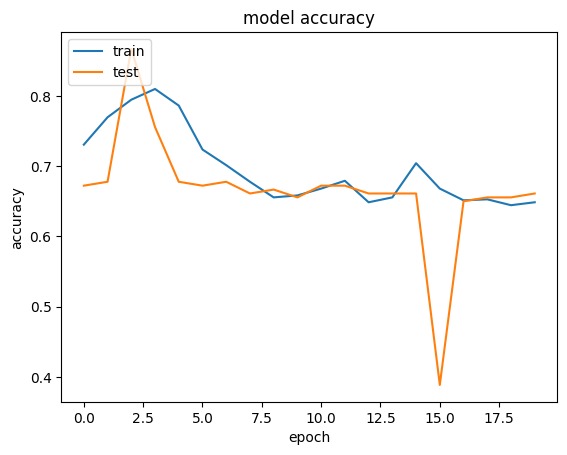

In [10]:
history = model.fit(train_data, train_targets, epochs=20, batch_size=batch_size, validation_data=(val_data, val_targets), verbose = 0)
plot_history(history)
model.save('drive/MyDrive/Uncertanty/model1.keras')

In [11]:
model = keras.models.load_model('drive/MyDrive/Uncertanty/model1.keras')

6/6 [==============================] - 1s 115ms/step


Text(50.722222222222214, 0.5, 'Actual')

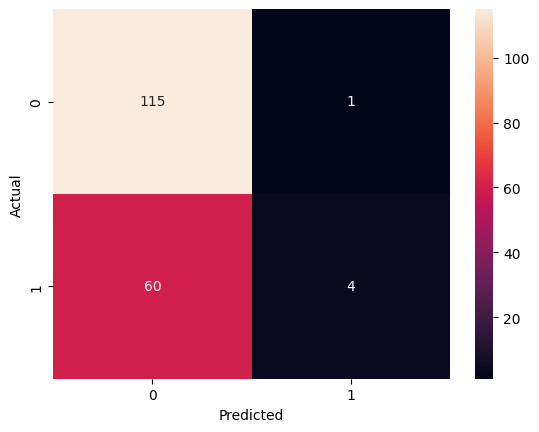

In [12]:
predict = model.predict(val_data)
sns.heatmap(confusion_matrix(val_targets, predict.round()), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')


This initial indication shows that there is a large error when the model predicts rotten fruit. This is problem. Lets see if we can find the cause of the error using uncertainty.

# Quantifying Uncertainty
There are several ways to quantify uncertainty.  

https://imerit.net/blog/a-comprehensive-introduction-to-uncertainty-in-machine-learning-all-una/

## Monte Carlo Dropout
The Monte Carlo method uses random probabilities to find the uncertainty.  The Monte Carlo Dropout, uses pseudo-random dropouts across many runs of the model prediction to create a set of models.  This set of similar predictions can be compared to each other to calculate uncertainty.

## Deep Ensembles
Like forests of trees, this network trains multiple models and calculates the uncertainty based on the drift between those varied models. This can do a better job of quantifying uncertainty.

## Deep Bayesian Active Learning (DBAL)
The Bayesian Method changes the dese blocks to a Bayesian Neural Network. This allows probabilities to be calculated.

# Going Forward
I will be using the Monte Carlo Dropout and Deep Bayesian Active Learning to calculate the uncertainty. Deep Ensembles took too long to train the model ensemble.

# Monte Carlo Dropout
To create a Monte Carlo Dropout, take the mode and add dropout layers into them.  There are 3 parts to creating a monte-Carlo dropout model.  The first is to add dropout layers.  I will add one after each pooling layer.  The second is to have the model use the dropout layer when performing the predict.  The third is to run predict many times to see the variation of different runs with different dropouts.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 normalization_1 (Normaliza  (None, 100, 100, 3)       7         
 tion)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0   

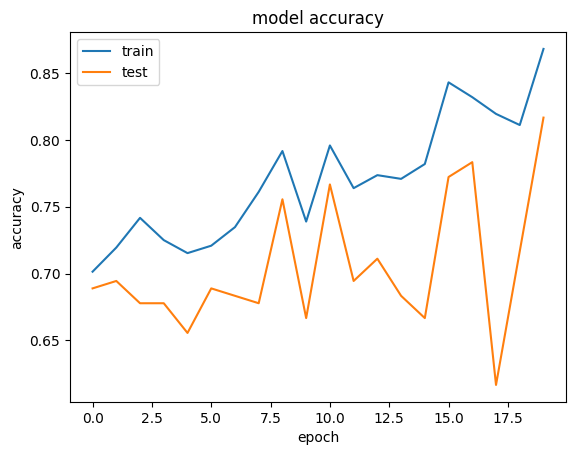

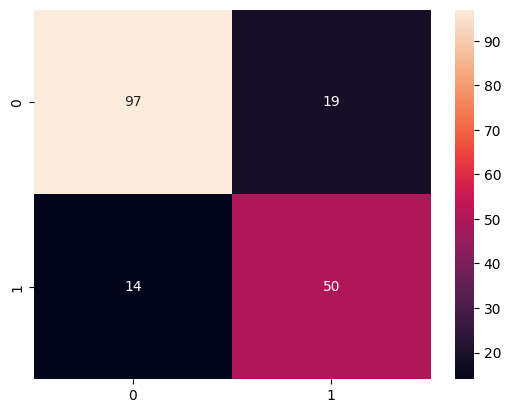

In [13]:
batch_size = 32
inputs = keras.Input(shape=(imagesize,imagesize,3))
x = keras.layers.Normalization()(inputs)
x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
# Added Dropout Layer
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
# Added Dropout Layer
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_data, train_targets, epochs=20, batch_size=batch_size, validation_data=(val_data, val_targets), verbose = 0)
predict = model.predict(val_data)
plot_history(history)
sns.heatmap(confusion_matrix(val_targets, predict.round()), annot=True, fmt='d')
# Results to keep the uncertanty results


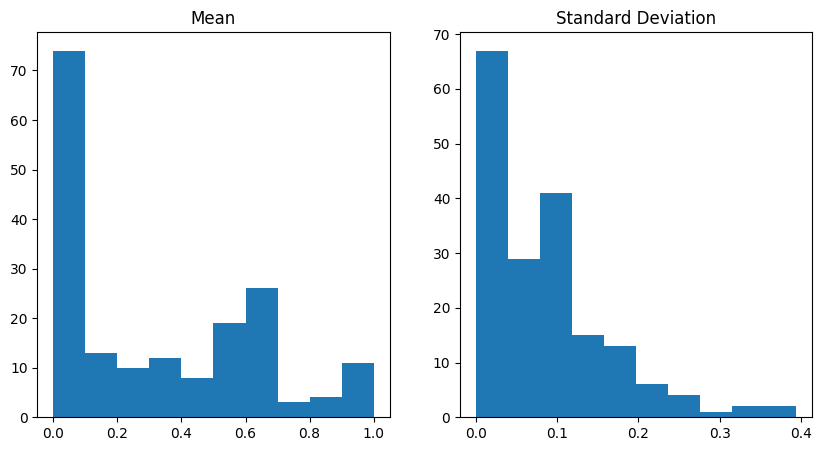

In [14]:
# Run predict 100 times
uncertain_samples = np.stack([model(val_data,training=True)
                  for sample in range(100)])
unified_results['Monte-Carlo'] = uncertain_samples
# Find Means and Std Deviation
mean = uncertain_samples.mean(axis=0)
std = uncertain_samples.std(axis=0)
# Graph
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(mean)
ax[0].set_title('Mean')
ax[1].hist(std)
ax[1].set_title('Standard Deviation')
plt.show()
#graph_uncertanty(uncertain_samples, val_data)

# Histogram Uncertainty Results
## Change in results
It is clear that adding dropout layers greatly changed the models’ predictions.  This could be due to an overfitting problem getting corrected.  This change demonstrates one of the biggest issues with the Monte-Carlo Uncertainty Measure.  It changes the model, which could change the outcome.

## Analysis of results
The histogram clearly shows 2 major things.
1. For most of the results, the mode is very unsure of which selection to make.
2. For most model runs, the uncertainty is very dense, with few models having a large standard deviation.

# Bayesian Uncertainty
To calculate Bayesian Uncertainty, I will replace the Conv2D and Dense Layers with TensorFlow Probability Blocks that will store Bayesian uncertainty.  I will also switch the loss function to a function that will handle uncertainty.

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 normalization_4 (Normaliza  (None, 100, 100, 3)       7         
 tion)                                                           
                                                                 
 conv2d_flipout_8 (Conv2DFl  (None, 98, 98, 32)        1760      
 ipout)                                                          
                                                                 
 conv2d_flipout_9 (Conv2DFl  (None, 96, 96, 64)        36928     
 ipout)                                                          
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                      

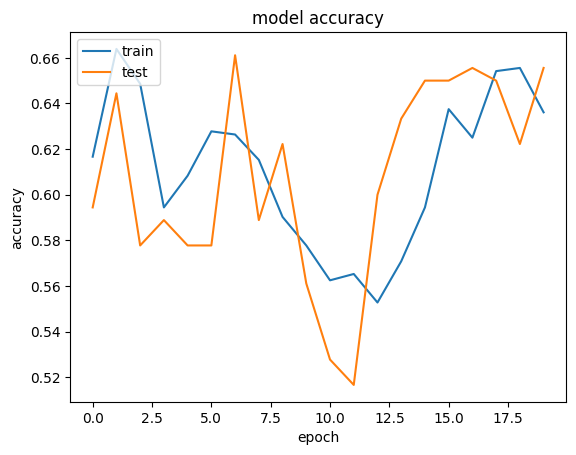

<Axes: >

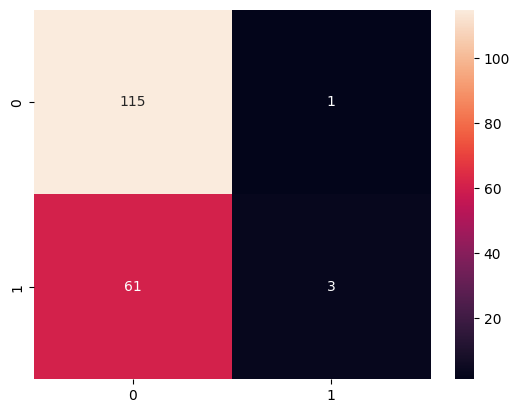

In [18]:
inputs = keras.Input(shape=(imagesize,imagesize,3))
x = keras.layers.Normalization()(inputs)
x = tfp.layers.Convolution2DFlipout(filters=32, kernel_size=3, activation='relu')(x)
x = tfp.layers.Convolution2DFlipout(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = tfp.layers.Convolution2DFlipout(filters=128, kernel_size=3, activation='relu')(x)
x = tfp.layers.Convolution2DFlipout(filters=256, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
outputs = tfp.layers.DenseFlipout(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_data, train_targets, epochs=20, batch_size=batch_size, validation_data=(val_data, val_targets), verbose = 0)
predict = model.predict(val_data)
plot_history(history)
sns.heatmap(confusion_matrix(val_targets, predict.round()), annot=True, fmt='d')

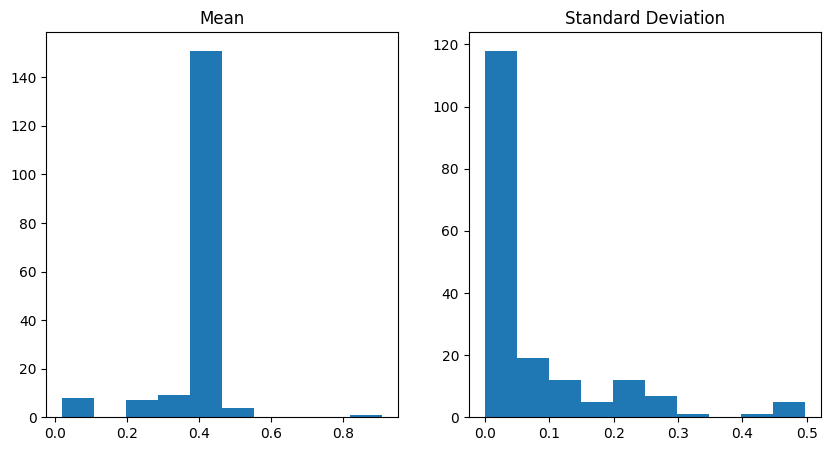

In [19]:
uncertain_samples = np.stack([model(val_data,training=True)
                  for sample in range(100)])
unified_results['Baysean'] = uncertain_samples
mean = uncertain_samples.mean(axis=0)
std = uncertain_samples.std(axis=0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(mean)
ax[0].set_title('Mean')
ax[1].hist(std)
ax[1].set_title('Standard Deviation')
plt.show()

# Bayesian Uncertainty Results
The Bayesian Uncertainty shows that the model using Bayesian models is extremely uncertain, with a fairly low overall standard deviation.  This shows the model is not currently sure about any results.

# Overall Results of a CNN Model
The CNN Model has a high level of uncertainty.  The optimal Uncertainty Chart would have a spike at 0 and a spike at 1, with no other spikes.

# Next Steps
I will try to optimize the model to get a better distribution of uncertainty results.  By Optimize, I mean grow.

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 normalization_7 (Normaliza  (None, 100, 100, 3)       7         
 tion)                                                           
                                                                 
 conv2d_flipout_24 (Conv2DF  (None, 98, 98, 32)        1760      
 lipout)                                                         
                                                                 
 conv2d_flipout_25 (Conv2DF  (None, 96, 96, 64)        36928     
 lipout)                                                         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                     

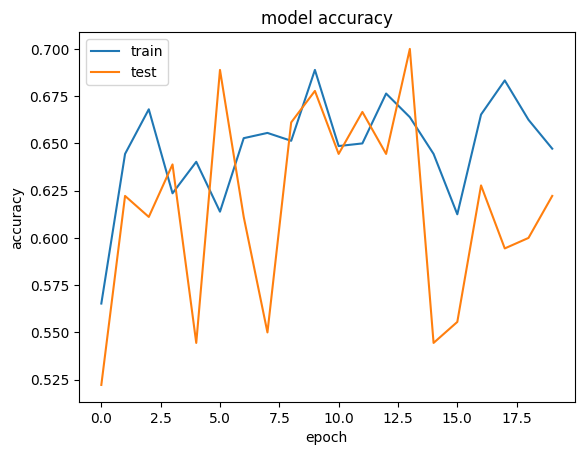

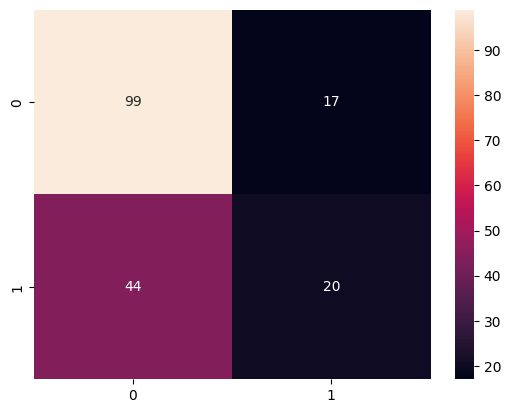

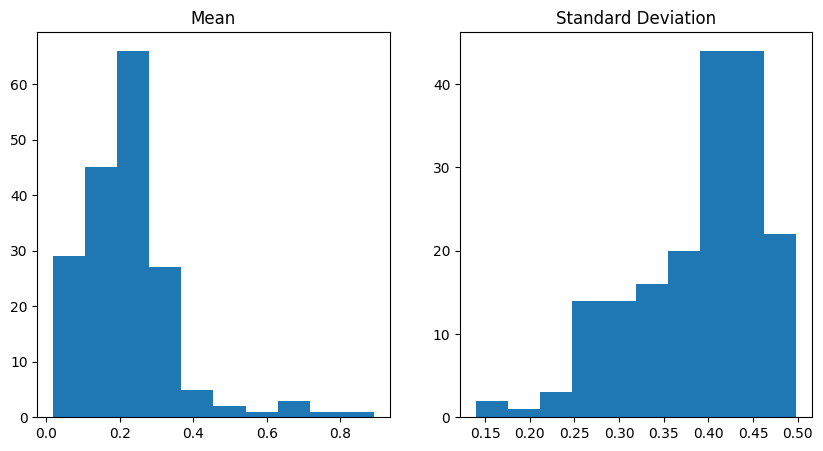

In [27]:
inputs = keras.Input(shape=(imagesize,imagesize,3))
x = keras.layers.Normalization()(inputs)
x = tfp.layers.Convolution2DFlipout(filters=32, kernel_size=3, activation='relu')(x)
x = tfp.layers.Convolution2DFlipout(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = tfp.layers.Convolution2DFlipout(filters=128, kernel_size=3, activation='relu')(x)
x = tfp.layers.Convolution2DFlipout(filters=256, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = tfp.layers.Convolution2DFlipout(filters=512, kernel_size=3, activation='relu')(x)
x = tfp.layers.Convolution2DFlipout(filters=1024, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
outputs = tfp.layers.DenseFlipout(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_data, train_targets, epochs=20, batch_size=batch_size, validation_data=(val_data, val_targets), verbose = 0)
predict = model.predict(val_data)
plot_history(history)
sns.heatmap(confusion_matrix(val_targets, predict.round()), annot=True, fmt='d')

uncertain_samples = np.stack([model(val_data,training=True)
                  for sample in range(100)])
unified_results['Monte-Carlo'] = uncertain_samples
mean = uncertain_samples.mean(axis=0)
std = uncertain_samples.std(axis=0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(mean)
ax[0].set_title('Mean')
ax[1].hist(std)
ax[1].set_title('Standard Deviation')
plt.show()

# A second shot of the Baysean Method
I tried to do a second round of the larger Baysean Model.  I couldn't go larger due to VRAM limitations.  This one did no better than the first.

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 normalization_1 (Normaliza  (None, 100, 100, 3)       7         
 tion)                                                           
                                                                 
 conv2d_flipout_6 (Conv2DFl  (None, 98, 98, 32)        1760      
 ipout)                                                          
                                                                 
 conv2d_flipout_7 (Conv2DFl  (None, 96, 96, 64)        36928     
 ipout)                                                          
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                      

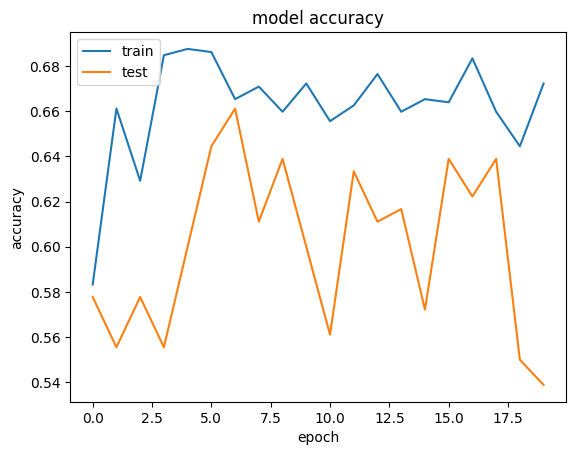

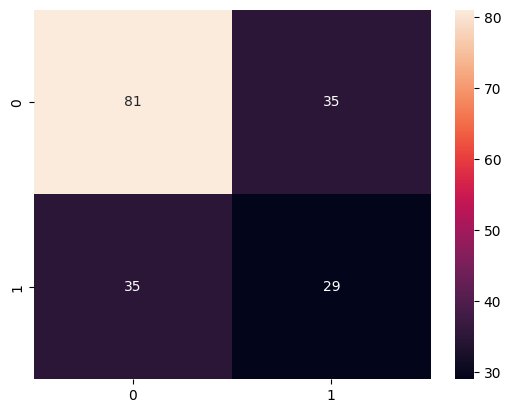

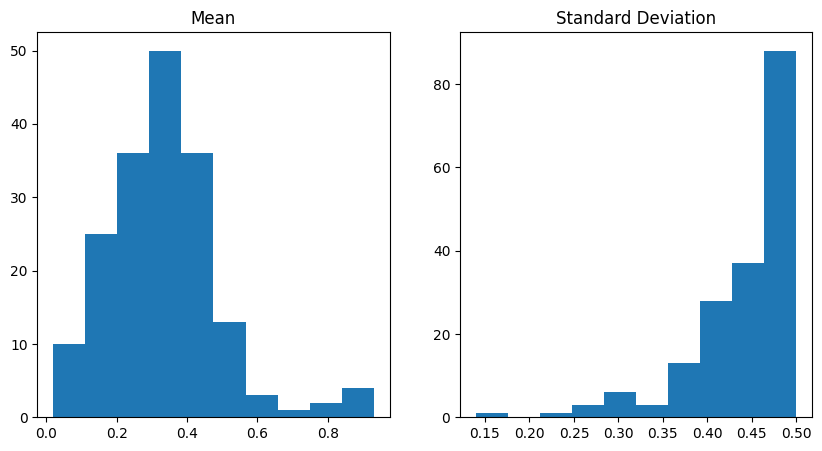

In [10]:
batch_size = 32
inputs = keras.Input(shape=(imagesize,imagesize,3))
x = keras.layers.Normalization()(inputs)
x = tfp.layers.Convolution2DFlipout(filters=32, kernel_size=3, activation='relu')(x)
x = tfp.layers.Convolution2DFlipout(filters=64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = tfp.layers.Convolution2DFlipout(filters=128, kernel_size=3, activation='relu')(x)
x = tfp.layers.Convolution2DFlipout(filters=256, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = tfp.layers.Convolution2DFlipout(filters=512, kernel_size=3, activation='relu')(x)
x = tfp.layers.Convolution2DFlipout(filters=1024, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPool2D(pool_size=2)(x)
x = keras.layers.Flatten()(x)
outputs = tfp.layers.DenseFlipout(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_data, train_targets, epochs=20, batch_size=batch_size, validation_data=(val_data, val_targets), verbose = 0)
predict = model.predict(val_data)
plot_history(history)
sns.heatmap(confusion_matrix(val_targets, predict.round()), annot=True, fmt='d')

uncertain_samples = np.stack([model(val_data,training=True)
                  for sample in range(100)])
unified_results['Baysean_Larger_2'] = uncertain_samples
mean = uncertain_samples.mean(axis=0)
std = uncertain_samples.std(axis=0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(mean)
ax[0].set_title('Mean')
ax[1].hist(std)
ax[1].set_title('Standard Deviation')
plt.show()

# Trying the larger models with a Monte-Carlo Approach
I will now revise the last models with a monte-carlo approach.  This is to get a better feel for the performance and check for errors in the baysean model.

I also switched to a Google TPU at this time for speed and VRAM.


All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 normalization (Normalizati  (None, 100, 100, 3)       7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896  

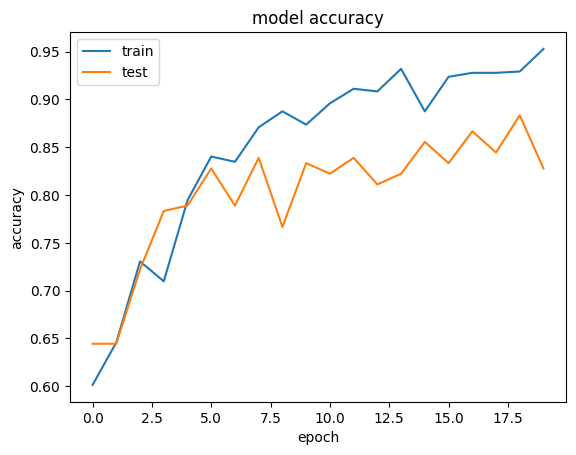

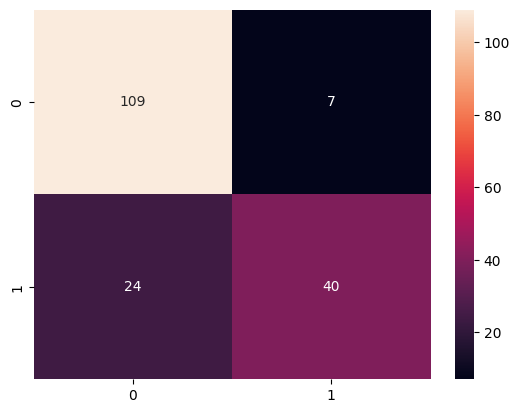

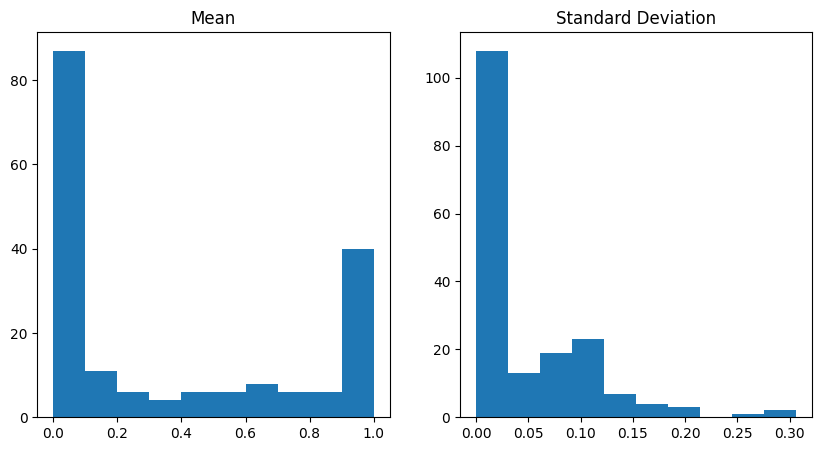

In [9]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)
batch_size = 32
with strategy.scope():
  inputs = keras.Input(shape=(imagesize,imagesize,3))
  x = keras.layers.Normalization()(inputs)
  x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=1024, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Flatten()(x)
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
history = model.fit(train_data, train_targets, epochs=20, batch_size=batch_size, validation_data=(val_data, val_targets), verbose = 0)
with strategy.scope():
  predict = model.predict(val_data)
plot_history(history)
sns.heatmap(confusion_matrix(val_targets, predict.round()), annot=True, fmt='d')
#def graph_uncertanty(model, val_data):
with strategy.scope():
  uncertain_samples = np.stack([model(val_data,training=True)
                    for sample in range(100)])
unified_results['Monte-Carlo-Bigger'] = uncertain_samples
mean = uncertain_samples.mean(axis=0)
std = uncertain_samples.std(axis=0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(mean)
ax[0].set_title('Mean')
ax[1].hist(std)
ax[1].set_title('Standard Deviation')
plt.show()
#graph_uncertanty(uncertain_samples, val_data)


# Finding the models Inaccuracies
I want to see if the model I built is certainly wrong, as that will demonstrate the limits of uncertainty.  As you can see, even at higher uncertainty scores, the model can be confidently wrong.  

As you can see from the results, there are models with a 95% certainty that are incorrectly classified.  This shows the limits of uncertainty and why things like LLMs will confidently give you an incorrect answer.

In [10]:
def find_wrong_uncertanties(uncertain_samples, val_targets):
  means = uncertain_samples.mean(axis=0)[:,0]
  test_vals = [.7, .75, .8, .85, .9, .95]
  for val in test_vals:
    print(f"Number of incorrectly classified values with > {val} in uncertanty {sum(val_targets[np.where(means > val)]==0)}")
  test_vals = [.3, .25, .2, .15, .1, .05]
  for val in test_vals:
    print(f"Number of incorrectly classified values with < {val} in uncertanty {sum(val_targets[np.where(means < val)]==1)}")
find_wrong_uncertanties(uncertain_samples, val_targets)

Number of incorrectly classified values with > 0.7 in uncertanty 6
Number of incorrectly classified values with > 0.75 in uncertanty 4
Number of incorrectly classified values with > 0.8 in uncertanty 3
Number of incorrectly classified values with > 0.85 in uncertanty 3
Number of incorrectly classified values with > 0.9 in uncertanty 2
Number of incorrectly classified values with > 0.95 in uncertanty 2
Number of incorrectly classified values with < 0.3 in uncertanty 7
Number of incorrectly classified values with < 0.25 in uncertanty 7
Number of incorrectly classified values with < 0.2 in uncertanty 4
Number of incorrectly classified values with < 0.15 in uncertanty 2
Number of incorrectly classified values with < 0.1 in uncertanty 2
Number of incorrectly classified values with < 0.05 in uncertanty 2


# Better Results
The Monte-Carlo Uncertainty method seems to have generated better results.  I don't know if this is an issue of my implementation or just a problem with the TensorFlow-Probability module.

You can see the 2 bars start to form on the edges of the uncertainty graph, and the overall model is becoming very sure of itself.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 normalization_1 (Normaliza  (None, 100, 100, 3)       7         
 tion)                                                           
                                                                 
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 48, 48, 64)        0   

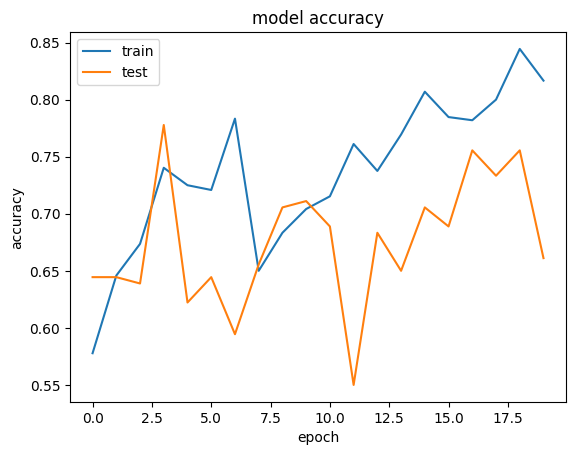

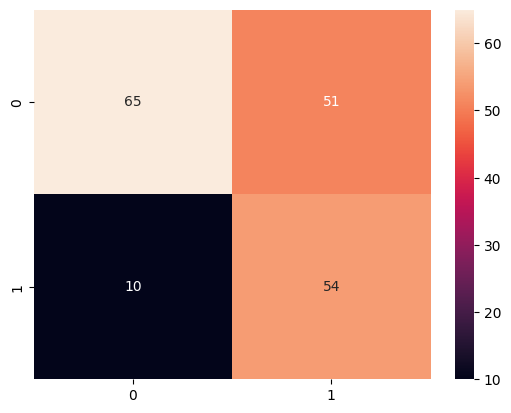

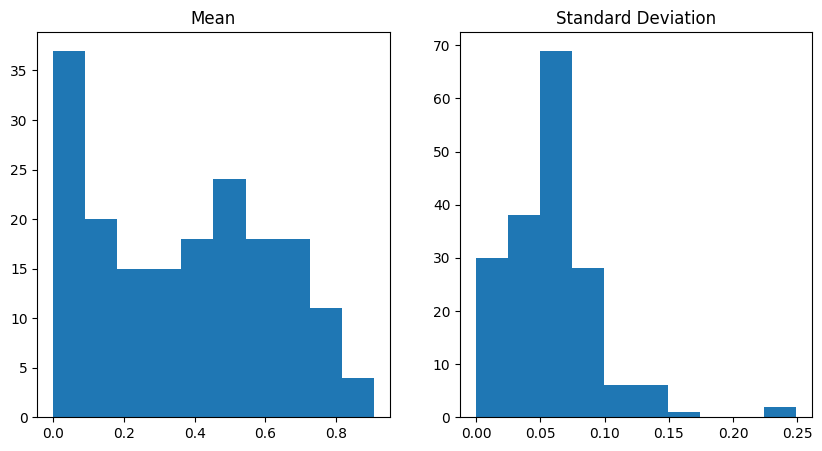

In [10]:
batch_size = 32
with strategy.scope():
  inputs = keras.Input(shape=(imagesize,imagesize,3))
  x = keras.layers.Normalization()(inputs)
  x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=1024, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Conv2D(filters=2048, kernel_size=3, activation='relu')(x)
  x = keras.layers.Conv2D(filters=4096, kernel_size=3, activation='relu')(x)
  x = keras.layers.MaxPool2D(pool_size=2)(x)
  x = keras.layers.Dropout(0.5)(x)
  x = keras.layers.Flatten()(x)
  outputs = keras.layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
history = model.fit(train_data, train_targets, epochs=20, batch_size=batch_size, validation_data=(val_data, val_targets), verbose = 0)
predict = model.predict(val_data)
plot_history(history)
sns.heatmap(confusion_matrix(val_targets, predict.round()), annot=True, fmt='d')
#def graph_uncertanty(model, val_data):
uncertain_samples = np.stack([model(val_data,training=True)
                  for sample in range(100)])
unified_results['Monte-Carlo-Bigger'] = uncertain_samples
mean = uncertain_samples.mean(axis=0)
std = uncertain_samples.std(axis=0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(mean)
ax[0].set_title('Mean')
ax[1].hist(std)
ax[1].set_title('Standard Deviation')
plt.show()
#graph_uncertanty(uncertain_samples, val_data)

# A step down
This larger model is a step down in accuracy shows a high level of uncertanty.  This is coorlated in both the uncertanty plot as well as the coorlation matrix.

# Final Results
As I have run out of VRAM in Google Colab, and my models are getting worse, and not better, I will stop here.  

Optimizing the model reduces the uncertainty of the model, but the model can be confident and wrong.  

# Conclusion

The concept of uncertainty is critically important to a variety of machine learning fields.  LLMs need to look at uncertainty to determine if it is confidently incorrect, while with some models, the uncertainty can be used to provide an error margin.  

In this case I showed that the Monte-Carlo method can accurately calculate uncertainty, and that even when uncertainty is low, and the model is confident, it can be confidently wrong.

## Lessons Learned
- Plan to run out of VRAM
- Uncertainty optimization is very similar in this case to accuracy.  The model can still be confidently inaccurate.
- I did not investigate to see if the model was confidently inaccurate.  
- It takes a long time to generate 100 sets of predictions, longer than it takes to train the whole model.